<h1> Board Games and Video Games Extension:</h1>
<h2>Looking Deeper into the Language</h2>
<h4> Dan Tadmor | Data Scientist</h4>

## Preface

The purpose of this notebook is to look more deeply into the languages of the subreddits and understand how people interact with each other in the different communities.

## Load the libraries

In [350]:
import requests
import json
import time
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import numpy as np
from nltk import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Load the data

In [351]:
board_games = pd.read_csv('./data/board_games')
video_games = pd.read_csv('./data/video_games')

## Find out how to split the data

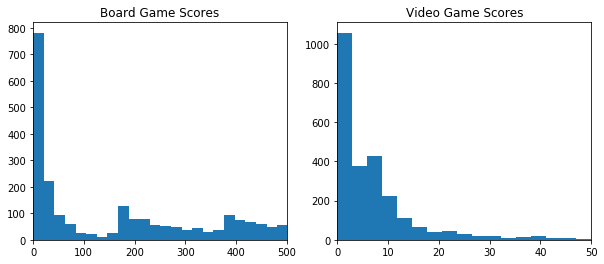

In [407]:
plt.subplots(figsize=(10,4))
plt.subplot(121)
plt.hist(board_games['score'], bins=1500)
plt.xlim(0,500)
plt.title('Board Game Scores')
plt.subplot(122)
plt.hist(video_games['score'], bins=50)
plt.xlim(0,50)
plt.title('Video Game Scores');

In [360]:
def group_finder(data, n_groups):
    
    # Prepare the data 
    sorted_data = sorted(data)
    max_bin_size = len(data)
    solutions = []
    
    # Iterate over different bin sizes to find the best size
    for n_bins in np.logspace(np.log10(n_groups), np.log10(max_bin_size), 50):
        
        bin_frequencies, bins = np.histogram(data, int(n_bins))
        start_points = []
        previous_frequency = 0
        jump_list = [0] * n_groups
        bins_list = [0] * n_groups
        
        # For each bin, check if the frequency "jump" is high enough to use it as a cutoff
        for bin_x, current_frequency in zip(bins, bin_frequencies):
            
            jump = (current_frequency - previous_frequency) * (current_frequency/(previous_frequency + 1))
            for i, jump_i in enumerate(jump_list):
            
                # If the jump is big enough, fix the jump and bins list
                if jump > jump_i:
                    jump_list.insert(i, jump)
                    jump_list.pop(-1)
                    bins_list.insert(i, bin_x)
                    bins_list.pop(-1)
                    break
                    
            # Update the previous frequency
            previous_frequency = current_frequency
        
        # Add the solutions to the list
        solutions.append([jump_list, bins_list])
    
    # Sort the solutions to have the solution with the highest minimum jump
    sorted_solutions = sorted(solutions, key=lambda x: min(x[0]), reverse=True)
    
    return sorted(sorted_solutions[0][1])

In [361]:
board_game_splits = group_finder(board_games['score'], 3)

In [362]:
video_game_splits = group_finder(video_games['score'], 3)

In [363]:
board_game_splits, video_game_splits

([0.0, 156.98311444652907, 372.83489681050656],
 [0.0, 0.9102167182662538, 6.826625386996904])

## Preparing the data for the models

In [364]:
def subreddit_score_simplifier(score, splits):
    
    # Given a score, it will determine what bucket it belongs in
    for i in range(len(splits)-1, -1, -1):
        if score >= splits[i]:
            return i

In [365]:
# Creating a new column for each dataframe with the bucketed scores
board_games['score_group'] = board_games['score'].apply(subreddit_score_simplifier, args=(board_game_splits,))
video_games['score_group'] = video_games['score'].apply(subreddit_score_simplifier, args=(video_game_splits,))

In [367]:
# Double checking that the scores worked and seeing the distribution
board_games['score_group'].value_counts()

0    1217
2     990
1     588
Name: score_group, dtype: int64

In [371]:
board_games['score_group'].isna().sum()

0

In [374]:
video_games['score_group'].value_counts()

1    1272
2     976
0     300
Name: score_group, dtype: int64

In [375]:
video_games['score_group'].isna().sum()

0

In [376]:
def  text_prep(text):

    # Remove the annoying '\n's
    text = re.sub("[^a-zA-Z]", " ", text)
    # Making all the letters to lower case
    words = text.lower().split()
    # Use a stemmer to find the word stems
    stem = PorterStemmer()
    words = [stem.stem(word) for word in words]
    # Remove the stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # return them back together to make a text
    text = ' '.join(words)
    
    return text

In [377]:
def doc_prep(df, columns):
    
    # Fill na columns with '' to prepare for NLP
    for column in columns:
        df[column].fillna('', inplace=True)
    
    # Clean all of the columns
    for column in columns:
        df[column] = df[column].map(text_prep)

In [378]:
# Preparing the text columns to be used for NLP models
columns = ['title', 'selftext', 'comments']
doc_prep(board_games, columns)
doc_prep(video_games, columns)

## Create models to predict the scoring bucket

In [382]:
# Creating the X and y dataframes for the models
X_bg, y_bg = board_games[columns], board_games['score_group']
X_vg, y_vg = video_games[columns], video_games['score_group']

In [383]:
# Splitting the data into training and testing sets
X_bg_train, X_bg_test, y_bg_train, y_bg_test = train_test_split(X_bg, y_bg, stratify=y_bg, random_state=42)
X_vg_train, X_vg_test, y_vg_train, y_vg_test = train_test_split(X_vg, y_vg, stratify=y_vg, random_state=42)
X_bg_train = pd.DataFrame(X_bg_train, columns=columns)
X_vg_train = pd.DataFrame(X_vg_train, columns=columns)

#### Predicting scores with titles

In [384]:
# Preparing the pipeline and gridsearch
steps = [
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('log', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
]

pipeline = Pipeline(steps=steps)

grid_params = {
    'log__C': [0.1, 0.5, 1, 5, 10, 50, 100]
}

In [385]:
# Searching over the pipeline
gs = GridSearchCV(pipeline, grid_params, verbose=1, cv=5)
bg_results = gs.fit(X_bg_train['title'], y_bg_train)
print(bg_results.best_score_)
vg_results = gs.fit(X_vg_train['title'], y_vg_train)
print(vg_results.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.1s finished


0.5596374045801527
Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.587650444793302


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.9s finished


In [386]:
bg_results.best_params_, vg_results.best_params_

({'log__C': 0.5}, {'log__C': 0.5})

In [411]:
# Model using the title of the board game posts
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
X_bg_train_vect = pd.DataFrame(tfidf.fit_transform(X_bg_train['title']).todense(), columns=tfidf.get_feature_names(),
                               index=X_bg_train.index)
X_bg_test_vect = pd.DataFrame(tfidf.transform(X_bg_test['title']).todense(), columns=tfidf.get_feature_names(),
                              index=X_bg_test.index)

log = LogisticRegression(C=.5, multi_class='multinomial', solver='lbfgs')
log.fit(X_bg_train_vect, y_bg_train)
print("Board Game Title Score", log.score(X_bg_test_vect, y_bg_test))

Board Game Title Score 0.5650929899856938


In [432]:
# Printing the best features and their strength
features_strength = zip(X_bg_train_vect.columns, log.coef_[0]);
print('Board Game Title to Score Predictors')
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)[:20]

Board Game Title to Score Predictors


[('amaz wish', -0.2904257595616866),
 ('adventur also', -0.2854936267430652),
 ('amp good', -0.24823294960660597),
 ('also includ', -0.19756182388279828),
 ('allur', -0.19745195146128525),
 ('age board', -0.1365101358108829),
 ('aggress', -0.1336829690431238),
 ('also seen', -0.1332893952307092),
 ('agreement', -0.12723128595826685),
 ('action take', -0.12441654130809542),
 ('almost none', -0.12105096966269653),
 ('also close', -0.11694487446881702),
 ('also offer', -0.11011948854658835),
 ('amazon http', -0.10930478490257456),
 ('actual care', -0.0963341831145998),
 ('almost got', -0.09218571441498274),
 ('amp utm', 0.09137461162394278),
 ('advanc civil', -0.0895560142580608),
 ('alreadi think', -0.085502691727868),
 ('amp ved', -0.08501338070393681)]

In [416]:
# Model using the title of the video game posts
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
X_vg_train_vect = pd.DataFrame(tfidf.fit_transform(X_vg_train['title']).todense(), columns=tfidf.get_feature_names(),
                               index=X_vg_train.index)
X_vg_test_vect = pd.DataFrame(tfidf.transform(X_vg_test['title']).todense(), columns=tfidf.get_feature_names(),
                              index=X_vg_test.index)

log = LogisticRegression(C=.5, multi_class='multinomial', solver='lbfgs')
log.fit(X_vg_train_vect, y_vg_train)
print("Video Game Title Score", log.score(X_vg_test_vect, y_vg_test))

Video Game Title Score 0.576138147566719


In [431]:
# Printing the best features and their strength
features_strength = zip(X_vg_train_vect.columns, log.coef_[0]);
print('Video Game Title to Score Predictors')
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)[:20]

Video Game Title to Score Predictors


[('thi', -0.2904257595616866),
 ('game', -0.2854936267430652),
 ('wa', -0.24823294960660597),
 ('play', -0.19756182388279828),
 ('like', -0.19745195146128525),
 ('get', -0.1365101358108829),
 ('good', -0.1336829690431238),
 ('realli', -0.1332893952307092),
 ('http', -0.12723128595826685),
 ('com', -0.12441654130809542),
 ('love', -0.12105096966269653),
 ('one', -0.11694487446881702),
 ('pretti', -0.11011948854658835),
 ('think', -0.10930478490257456),
 ('could', -0.0963341831145998),
 ('look', -0.09218571441498274),
 ('word', 0.09137461162394278),
 ('fuck', -0.0895560142580608),
 ('much', -0.085502691727868),
 ('work', -0.08501338070393681)]

#### Predicting scores with post text

In [391]:
# Preparing the pipeline and gridsearch
steps = [
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=4)),
    ('log', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
]

pipeline = Pipeline(steps=steps)

grid_params = {
    'log__C': [0.1, 0.5, 1, 5, 10, 50, 100]
}

In [392]:
# Searching over the pipeline
gs = GridSearchCV(pipeline, grid_params, verbose=1, cv=5)
bg_results = gs.fit(X_bg_train['selftext'], y_bg_train)
print(bg_results.best_score_)
vg_results = gs.fit(X_vg_train['selftext'], y_vg_train)
print(vg_results.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   33.1s finished


0.5877862595419847
Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.49921507064364207


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.6s finished


In [393]:
bg_results.best_params_, vg_results.best_params_

({'log__C': 0.1}, {'log__C': 0.1})

In [420]:
# Model using the text of the board game posts
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=4)
X_bg_train_vect = pd.DataFrame(tfidf.fit_transform(X_bg_train['selftext']).todense(),
                               columns=tfidf.get_feature_names(), index=X_bg_train.index)
X_bg_test_vect = pd.DataFrame(tfidf.transform(X_bg_test['selftext']).todense(), columns=tfidf.get_feature_names(),
                              index=X_bg_test.index)

log = LogisticRegression(C=.1, multi_class='multinomial', solver='lbfgs')
log.fit(X_bg_train_vect, y_bg_train)
print("Board Game Posts Score", log.score(X_bg_test_vect, y_bg_test))

Board Game Posts Score 0.5593705293276109


In [430]:
# Printing the best features and their strength
features_strength = zip(X_bg_train_vect.columns, log.coef_[0]);
print('Board Game Posts to Score Predictors')
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)[:20]

Board Game Posts to Score Predictors


[('amaz wish', -0.2904257595616866),
 ('adventur also', -0.2854936267430652),
 ('amp good', -0.24823294960660597),
 ('also includ', -0.19756182388279828),
 ('allur', -0.19745195146128525),
 ('age board', -0.1365101358108829),
 ('aggress', -0.1336829690431238),
 ('also seen', -0.1332893952307092),
 ('agreement', -0.12723128595826685),
 ('action take', -0.12441654130809542),
 ('almost none', -0.12105096966269653),
 ('also close', -0.11694487446881702),
 ('also offer', -0.11011948854658835),
 ('amazon http', -0.10930478490257456),
 ('actual care', -0.0963341831145998),
 ('almost got', -0.09218571441498274),
 ('amp utm', 0.09137461162394278),
 ('advanc civil', -0.0895560142580608),
 ('alreadi think', -0.085502691727868),
 ('amp ved', -0.08501338070393681)]

In [422]:
# Model using the text of the video game posts
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=4)
X_vg_train_vect = pd.DataFrame(tfidf.fit_transform(X_vg_train['selftext']).todense(), columns=tfidf.get_feature_names(),
                               index=X_vg_train.index)
X_vg_test_vect = pd.DataFrame(tfidf.transform(X_vg_test['selftext']).todense(), columns=tfidf.get_feature_names(),
                              index=X_vg_test.index)

log = LogisticRegression(C=.1, multi_class='multinomial', solver='lbfgs')
log.fit(X_vg_train_vect, y_vg_train)
print("Video Game Posts Score", log.score(X_vg_test_vect, y_vg_test))

Video Game Posts Score 0.49921507064364207


In [429]:
# Printing the best features and their strength
features_strength = zip(X_vg_train_vect.columns, log.coef_[0]);
print('Video Game Posts to Score Predictors')
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)[:20]

Video Game Posts to Score Predictors


[('thi', -0.2904257595616866),
 ('game', -0.2854936267430652),
 ('wa', -0.24823294960660597),
 ('play', -0.19756182388279828),
 ('like', -0.19745195146128525),
 ('get', -0.1365101358108829),
 ('good', -0.1336829690431238),
 ('realli', -0.1332893952307092),
 ('http', -0.12723128595826685),
 ('com', -0.12441654130809542),
 ('love', -0.12105096966269653),
 ('one', -0.11694487446881702),
 ('pretti', -0.11011948854658835),
 ('think', -0.10930478490257456),
 ('could', -0.0963341831145998),
 ('look', -0.09218571441498274),
 ('word', 0.09137461162394278),
 ('fuck', -0.0895560142580608),
 ('much', -0.085502691727868),
 ('work', -0.08501338070393681)]

#### Predicting scores with comments

In [398]:
# Preparing the pipeline and gridsearch
steps = [
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5)),
    ('log', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
]

pipeline = Pipeline(steps=steps)

grid_params = {
    'log__C': [0.1, 0.5, 1, 5, 10, 50, 100]
}

In [399]:
# Searching over the pipeline
gs = GridSearchCV(pipeline, grid_params, verbose=1, cv=5)
bg_results = gs.fit(X_bg_train['comments'], y_bg_train)
print(bg_results.best_score_)
vg_results = gs.fit(X_vg_train['comments'], y_vg_train)
print(vg_results.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.2min finished


0.7018129770992366
Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.5818942961800104


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.2s finished


In [400]:
bg_results.best_params_, vg_results.best_params_

({'log__C': 1}, {'log__C': 1})

In [423]:
# Model using the comments of the board game posts
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5)
X_bg_train_vect = pd.DataFrame(tfidf.fit_transform(X_bg_train['comments']).todense(), columns=tfidf.get_feature_names(),
                               index=X_bg_train.index, )
X_bg_test_vect = pd.DataFrame(tfidf.transform(X_bg_test['comments']).todense(), columns=tfidf.get_feature_names(),
                              index=X_bg_test.index, )

log = LogisticRegression(C=.1, multi_class='multinomial', solver='lbfgs')
log.fit(X_bg_train_vect, y_bg_train)
print("Board Game Comments Score", log.score(X_bg_test_vect, y_bg_test))

Board Game Comments Score 0.6323319027181689


In [428]:
# Printing the best features and their strength
features_strength = zip(X_bg_train_vect.columns, log.coef_[0]);
print('Board Game Comments to Score Predictors')
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)[:20]

Board Game Comments to Score Predictors


[('amaz wish', -0.2904257595616866),
 ('adventur also', -0.2854936267430652),
 ('amp good', -0.24823294960660597),
 ('also includ', -0.19756182388279828),
 ('allur', -0.19745195146128525),
 ('age board', -0.1365101358108829),
 ('aggress', -0.1336829690431238),
 ('also seen', -0.1332893952307092),
 ('agreement', -0.12723128595826685),
 ('action take', -0.12441654130809542),
 ('almost none', -0.12105096966269653),
 ('also close', -0.11694487446881702),
 ('also offer', -0.11011948854658835),
 ('amazon http', -0.10930478490257456),
 ('actual care', -0.0963341831145998),
 ('almost got', -0.09218571441498274),
 ('amp utm', 0.09137461162394278),
 ('advanc civil', -0.0895560142580608),
 ('alreadi think', -0.085502691727868),
 ('amp ved', -0.08501338070393681)]

In [425]:
# Model using the comments of the video game posts
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=4)
X_vg_train_vect = pd.DataFrame(tfidf.fit_transform(X_vg_train['comments']).todense(), columns=tfidf.get_feature_names(),
                               index=X_vg_train.index)
X_vg_test_vect = pd.DataFrame(tfidf.transform(X_vg_test['comments']).todense(), columns=tfidf.get_feature_names(),
                              index=X_vg_test.index)

log = LogisticRegression(C=.1, multi_class='multinomial', solver='lbfgs')
log.fit(X_vg_train_vect, y_vg_train)
print("Video Game Comments Score", log.score(X_vg_test_vect, y_vg_test))

Video Game Comments Score 0.5839874411302983


In [427]:
# Printing the best features and their strength
features_strength = zip(X_vg_train_vect.columns, log.coef_[0])
print('Video Game Comments to Score Predictors')
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)[:20]

Video Game Comments to Score Predictors


[('thi', -0.2904257595616866),
 ('game', -0.2854936267430652),
 ('wa', -0.24823294960660597),
 ('play', -0.19756182388279828),
 ('like', -0.19745195146128525),
 ('get', -0.1365101358108829),
 ('good', -0.1336829690431238),
 ('realli', -0.1332893952307092),
 ('http', -0.12723128595826685),
 ('com', -0.12441654130809542),
 ('love', -0.12105096966269653),
 ('one', -0.11694487446881702),
 ('pretti', -0.11011948854658835),
 ('think', -0.10930478490257456),
 ('could', -0.0963341831145998),
 ('look', -0.09218571441498274),
 ('word', 0.09137461162394278),
 ('fuck', -0.0895560142580608),
 ('much', -0.085502691727868),
 ('work', -0.08501338070393681)]